#### Saliency Maps

The most common methods involve calculating the gradient of the output score with respect to the input image, which highlights how much each pixel affects the final prediction.

In [13]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Import OpenCV for resizing

Predicted class: 244, Tibetan_mastiff (0.5909)


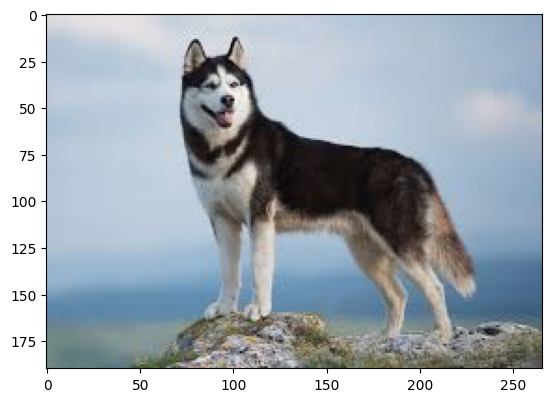

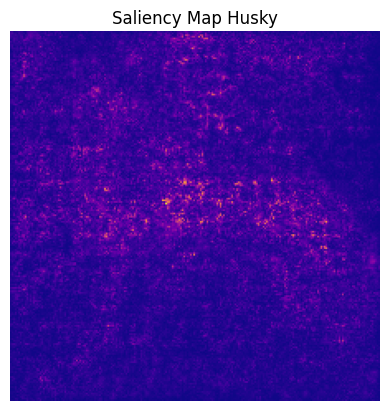

In [14]:
# Download and load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load and preprocess the input image
img_path = 'husky.jpg'
img = Image.open(img_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,  
 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model  

input_batch.requires_grad_()

# Forward pass
with torch.no_grad():  # No need to track gradients for prediction
    output = model(input_batch)

# Get the predicted class
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class_index = torch.argmax(probabilities).item()

# Load the ImageNet class labels
with open('imagenet_classes.txt', 'r') as f:
    categories = [s.strip() for s in f.readlines()]

predicted_class_name = categories[predicted_class_index]
confidence = probabilities[predicted_class_index].item()

print(f"Predicted class: {predicted_class_name} ({confidence:.4f})")

# Display Image
plt.imshow(img)
plt.show()

# Forward pass
output = model(input_batch)

# Get the predicted class
class_idx = torch.argmax(output).item()

# Compute the gradient of the output with respect to the input image
output[0, class_idx].backward()

# Get the gradients
grads = input_batch.grad.data.abs()

# Process the gradients (e.g., take absolute value and average across color channels)
saliency, _ = torch.max(grads, dim=1)
saliency = saliency.squeeze()

# Visualize the saliency map
plt.imshow(saliency.numpy(), cmap='plasma')
plt.title('Saliency Map Husky')
plt.axis('off')
plt.show()

#### Overlay image and saliency map

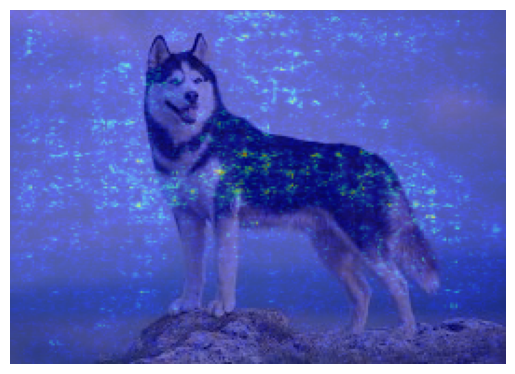

In [15]:
# --- Overlay the saliency map ---
# Convert the saliency map to a numpy array and normalize to 0-255
saliency_np = saliency.numpy()
saliency_np = (saliency_np - saliency_np.min()) / (saliency_np.max() - saliency_np.min()) * 255
saliency_np = saliency_np.astype(np.uint8)

# Convert the input image to a numpy array
img_np = np.array(img)

# Apply a colormap to the saliency map (e.g., 'jet')
from matplotlib import cm
saliency_colored = cm.jet(saliency_np)[:, :, :3]  # Remove alpha channel

# Resize the saliency map to match the original image dimensions
saliency_colored = cv2.resize(saliency_colored, (img_np.shape[1], img_np.shape[0]))

# Blend the original image with the colored saliency map
alpha = 0.5  # Adjust the transparency of the saliency map
overlay = img_np * (1 - alpha) + saliency_colored * alpha * 255
overlay = overlay.astype(np.uint8)

# Display the overlay
plt.imshow(overlay)
plt.axis('off')
plt.show()